In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

### Defining Transforms

In [2]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        # Requirements for pretrained models:
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        # Requirements for pretrained models:
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [3]:
from torch.utils.data import Dataset
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, root_dir, label_file, class_names, class_to_idx, transform):
        self.root_dir = root_dir
        self.label_file = label_file
        self.class_names = class_names
        self.class_to_idx = class_to_idx
        self.transform = transform

        # Read the labels from the Excel file
        self.labels = pd.read_excel(label_file, usecols=[3], names=['smiling'])['smiling'].tolist()

        # Get the list of image files (without the lambda it was not in order)
        self.image_files = []
        for root, dirs, files in os.walk(root_dir): 
            self.image_files.extend([os.path.join(root, file) for file in sorted(files, key=lambda x: int(''.join(filter(str.isdigit, x))))])


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the image and apply the transformation
        image = Image.open(self.image_files[idx])
        if self.transform:
            image = self.transform(image)

        # Convert the label to a tensor
        label = torch.tensor(self.labels[idx])
        
        return image, label

# Define the root directory of the dataset and the label file
root_dir = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23\celeba\img'
label_file = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23\celeba\labels.xlsx'
root_dir_test = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23_test\celeba_test\img'
label_file_test = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23_test\celeba_test\labels.xlsx'

# Define the class names and their corresponding indexes
class_names = ['Smile', 'NoSmile']
class_to_idx = {'Smile': 1, 'NoSmile': -1}

train_data = MyDataset(root_dir, label_file, class_names, class_to_idx, transform=train_transform)
test_data = MyDataset(root_dir_test, label_file_test, class_names, class_to_idx, transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')



['Smile', 'NoSmile']
Training images available: 5000
Testing images available:  1000


# Using pre trained model

In [4]:
ConvNextTinymodel = models.convnext_tiny(pretrained=True)
ConvNextTinymodel

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [5]:
# Freezing parameters
for param in ConvNextTinymodel.parameters():
    param.requires_grad = False
  
# modifying classifier
torch.manual_seed(42)

ConvNextTinymodel.classifier[2].out_features = 2
ConvNextTinymodel.classifier.add_module('LogSoftMax',nn.LogSoftmax(dim=1))

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ConvNextTinymodel.classifier.parameters(), lr=0.001)

for param in ConvNextTinymodel.classifier.parameters():
    param.requires_grad = True




In [6]:
for param in ConvNextTinymodel.parameters():
    print(param.requires_grad)


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [7]:
import time
start_time = time.time()

epochs = 10

max_trn_batch = 78 # 78 * 64 = 4992
max_tst_batch = 15 # 15 * 64 = 960

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
        
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Changing the labels to be in the range [0, num_classes-1].
        y_train = torch.where(y_train == 1, torch.tensor(1), torch.tensor(0))


        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = ConvNextTinymodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%(max_trn_batch/2) == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{64*b:4}/4992]  loss: {loss.item():10.8f}  \  accuracy: {trn_corr.item()*100/(64*b):7.2f}%')

    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Changing the labels to be in the range [0, num_classes-1].
            y_test = torch.where(y_test == 1, torch.tensor(1), torch.tensor(0))

            # Apply the model
            y_val = ConvNextTinymodel(X_test)
            loss = criterion(y_val, y_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    
    test_losses.append(loss.item())
    test_correct.append(tst_corr.item())

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:   39 [2496/4992]  loss: 0.76191843  \  accuracy:   32.69%
epoch:  0  batch:   78 [4992/4992]  loss: 0.58793706  \  accuracy:   48.96%
epoch:  1  batch:   39 [2496/4992]  loss: 0.52294546  \  accuracy:   73.24%
epoch:  1  batch:   78 [4992/4992]  loss: 0.47952315  \  accuracy:   74.16%
epoch:  2  batch:   39 [2496/4992]  loss: 0.43244100  \  accuracy:   76.32%
epoch:  2  batch:   78 [4992/4992]  loss: 0.32449260  \  accuracy:   77.30%
epoch:  3  batch:   39 [2496/4992]  loss: 0.46739569  \  accuracy:   79.37%
epoch:  3  batch:   78 [4992/4992]  loss: 0.53881449  \  accuracy:   79.83%
epoch:  4  batch:   39 [2496/4992]  loss: 0.36994693  \  accuracy:   81.21%
epoch:  4  batch:   78 [4992/4992]  loss: 0.42659074  \  accuracy:   80.77%
epoch:  5  batch:   39 [2496/4992]  loss: 0.32387379  \  accuracy:   80.97%
epoch:  5  batch:   78 [4992/4992]  loss: 0.42588934  \  accuracy:   81.77%
epoch:  6  batch:   39 [2496/4992]  loss: 0.27756825  \  accuracy:   81.53%
epoch:  6  b

In [8]:
torch.save(ConvNextTinymodel.state_dict(), 'A2ConvNextTinyModel.pt')

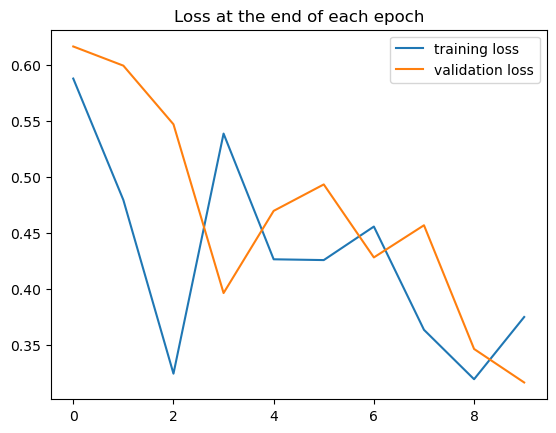

In [9]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

[679, 720, 747, 769, 775, 768, 755, 780, 782, 774]
Test accuracy: 80.625%


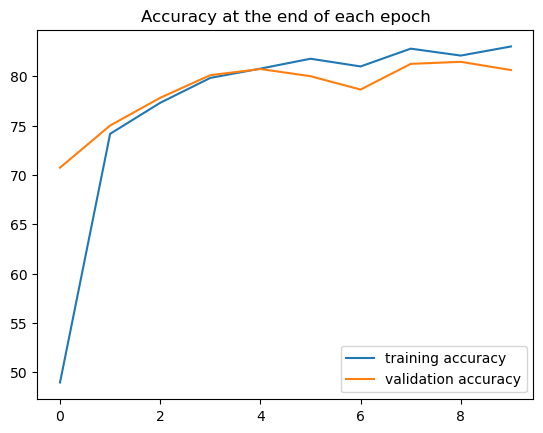

In [10]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1]*100/960:.3f}%')

plt.plot([t/49.92 for t in train_correct], label='training accuracy')
plt.plot([t/9.60 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();